#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma: float = 1.0, beta: float = 1.0) -> float:
    """
    Logistic loss + Elastic Net (bias w0 не регуляризуем):
        L = data_loss + gamma * ||w||_1 + beta * ||w||_2^2
    Поддерживает метки {0,1} и {-1,1}. Используются численно устойчивые формулы.
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    w = np.asarray(w, dtype=float)

    z = X @ w + w0  # (N,)

    if np.min(y) < 0:  # метки {-1,1}
        yz = y * z
        # softplus(-yz) = log(1 + exp(-yz)) со стабилизацией по знаку
        neg = yz < 0
        t = np.empty_like(yz)
        t[~neg] = np.log1p(np.exp(-yz[~neg]))
        t[neg]  = -yz[neg] + np.log1p(np.exp(yz[neg]))
        data_loss = float(np.mean(t))
    else:              # метки {0,1}
        # σ(z) без отдельной функции (стабильно)
        p = np.where(z >= 0, 1.0 / (1.0 + np.exp(-z)), np.exp(z) / (1.0 + np.exp(z)))
        eps = 1e-12
        data_loss = float(np.mean(-y * np.log(p + eps) - (1.0 - y) * np.log(1.0 - p + eps)))

    # Elastic Net (только на w; grad по L2 будет 2*beta*w)
    reg = gamma * np.linalg.norm(w, 1) + beta * float(w @ w)
    return data_loss + reg


#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma: float = 1., beta: float = 1.) -> Tuple[List[float], float]:
    """
    Градиенты (grad_w, grad_w0) для логистической регрессии с Elastic Net.
    ВАЖНО: как в задании — используется формула с y∈{0,1}:
        grad_w  = -(1/N) X^T ( y / (1 + exp(y * z)) ) + gamma * sign(w) + 2*beta*w
        grad_w0 = -(1/N) sum_i  y_i / (1 + exp(y_i * z_i))
    где z = Xw + w0.  Bias НЕ регуляризуем.
    """
    X = np.asarray(X, dtype=float)    # (N, d)
    y = np.asarray(y, dtype=float)    # (N,)
    w = np.asarray(w, dtype=float)    # (d,)
    N = X.shape[0]

    z = X @ w + w0                    # (N,)
    denom = 1.0 + np.exp(y * z)       # (N,)
    frac  = y / denom                 # (N,)

    # эмпирическая часть
    grad_w = -(X.T @ frac) / N
    grad_w0 = float(-np.sum(frac) / N)

    # регуляризация только на w
    if beta != 0.0:
        grad_w = grad_w + 2.0 * beta * w
    if gamma != 0.0:
        s = np.sign(w)
        s[w == 0.0] = 0.0             # допустимый субградиент на нуле
        grad_w = grad_w + gamma * s

    return grad_w.tolist(), grad_w0



In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta: float = 1.0, gamma: float = 1.0,
                 lr: float = 1e-2, tolerance: float = 1e-8,
                 max_iter: int = 1000, random_state: int = 42):
        """
        beta     — коэффициент L2 (в get_grad даёт вклад 2*beta*w)
        gamma    — коэффициент L1 (subgrad sign(w))
        lr       — шаг SGD
        tolerance— критерий останова по изменению лосса между эпохами
        max_iter — максимум эпох
        random_state — сид перемешивания
        """
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state

        # будут заполнены в fit
        self.w_ = None
        self.w0_ = None
        self.loss_history_ = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n, d = X.shape

        # детерминированная инициализация
        self.w_ = np.zeros(d, dtype=float)
        self.w0_ = 0.0
        self.loss_history_ = []

        rng = np.random.RandomState(self.random_state)
        last_loss = np.inf

        for _ in range(self.max_iter):
            # перемешивание индексов
            order = rng.permutation(n)

            # классический SGD (по одному объекту)
            for i in order:
                xi = X[i:i+1]
                yi = y[i:i+1]

                grad_w, grad_w0 = get_grad(xi, yi, self.w_, self.w0_,
                                           gamma=self.gamma, beta=self.beta)
                self.w_  = self.w_  - self.lr * np.asarray(grad_w)
                self.w0_ = self.w0_ - self.lr * grad_w0

            # контроль лосса и критерий останова
            cur_loss = loss(X, y, self.w_, self.w0_, gamma=self.gamma, beta=self.beta)
            self.loss_history_.append(cur_loss)
            if abs(last_loss - cur_loss) < self.tolerance:
                break
            last_loss = cur_loss

        return self

    def predict_proba(self, X):
        """Вернёт вероятности классов в формате sklearn: [P(class=0), P(class=1)]."""
        X = np.asarray(X, dtype=float)
        z = X @ self.w_ + self.w0_
        # стабильная σ(z) inline
        p1 = np.where(z >= 0, 1.0 / (1.0 + np.exp(-z)),
                      np.exp(z) / (1.0 + np.exp(z)))
        return np.vstack([1.0 - p1, p1]).T

    def predict(self, X):
        """Бинарные метки (порог 0.5)."""
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

In [7]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [8]:
def plot_decision_boundary(model, X, y):
    """
    Рисует точки (X, y) и разделяющую кривую модели логистической регрессии.
    Ожидается 2D-признаковое пространство (n_samples, 2) и бинарные метки {0,1} или {-1,1}.
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y)

    if X.shape[1] != 2:
        raise ValueError("plot_decision_boundary ожидает X с ровно 2 признаками.")

    # диапазон с небольшим полем
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    # сетка для оценки вероятностей
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # получить P(class=1)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(grid)[:, 1]
    elif hasattr(model, "w_") and hasattr(model, "w0_"):
        z = grid @ model.w_[:2] + model.w0_
        proba = 1.0 / (1.0 + np.exp(-z))
    else:
        raise AttributeError("Модель должна иметь predict_proba(...) или (w_, w0_).")

    Z = proba.reshape(xx.shape)

    # рисуем
    plt.figure(figsize=(6, 5))
    # фон вероятностей
    cs = plt.contourf(xx, yy, Z, levels=50, alpha=0.35)
    # линия P=0.5 — граница решений
    plt.contour(xx, yy, Z, levels=[0.5], linewidths=2)

    # точки датасета
    # приводим {-1,1} к {0,1} для корректной окраски
    y01 = (y > 0).astype(int)
    plt.scatter(X[:, 0], X[:, 1], c=y01, edgecolors='k', s=40)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Decision boundary")
    plt.colorbar(cs, label="P(class=1)")
    plt.show()


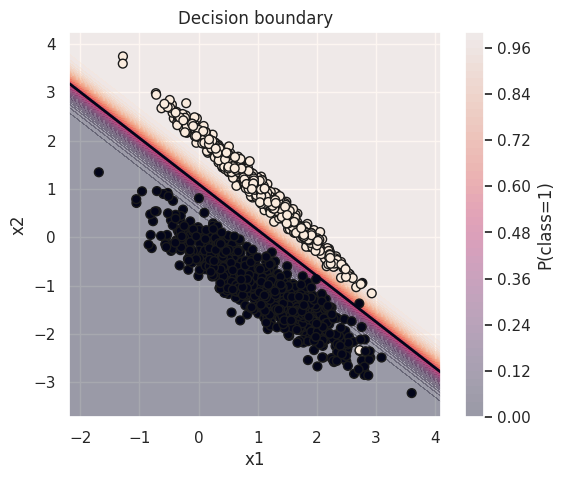

In [9]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [10]:
def plot_loss_history(model):
    """
    Отобразить изменение функции потерь по эпохам обучения.
    Ожидает, что у модели есть атрибут `loss_history_` (список значений loss).
    """
    if not hasattr(model, "loss_history_"):
        raise AttributeError("У модели нет атрибута loss_history_. Сначала вызови fit().")

    loss_hist = np.asarray(model.loss_history_, dtype=float)
    if loss_hist.size == 0:
        raise ValueError("loss_history_ пуст. Вероятно, обучение не запускалось или прервалось.")

    iters = np.arange(1, loss_hist.size + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(iters, loss_hist, marker='o', linewidth=1)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training loss over epochs")
    # отметим лучший (минимальный) лосс
    k = int(np.argmin(loss_hist))
    plt.scatter(iters[k], loss_hist[k])
    plt.annotate(f"min={loss_hist[k]:.4g}\nepoch={iters[k]}",
                 (iters[k], loss_hist[k]), xytext=(5, 10),
                 textcoords="offset points")
    plt.tight_layout()
    plt.show()


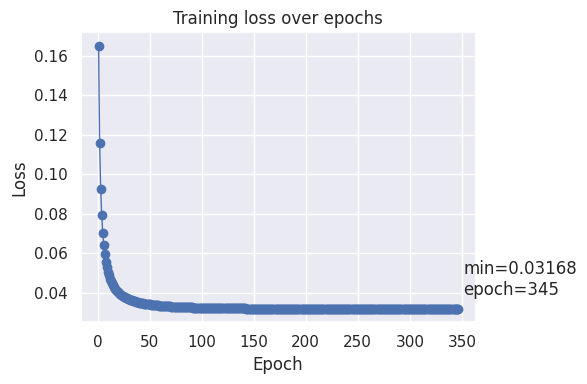

In [11]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# подготовка данных: y в {0,1} (на случай, если сейчас {-1,1})
y01 = (np.asarray(y) > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    np.asarray(X, dtype=float), y01, test_size=0.3, random_state=42, stratify=y01
)

kernels = ["linear", "rbf", "poly", "sigmoid"]
Cs = [0.1, 1, 3, 10]

rows = []
for ker in kernels:
    for C in Cs:
        clf = SVC(kernel=ker, C=C, gamma="scale", degree=3, probability=False, random_state=42)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        # баллы для AUC
        scores = clf.decision_function(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, scores)

        rows.append({"kernel": ker, "C": C, "Acc": acc, "Precision": prec,
                     "Recall": rec, "F1": f1, "AUC-ROC": auc})

results = pd.DataFrame(rows).sort_values(["AUC-ROC", "F1", "Acc"], ascending=False).reset_index(drop=True)
results


,kernel,C,Acc,Precision,Recall,F1,AUC-ROC
0,rbf,1.0,0.994444,0.992620,0.996296,0.994455,0.997791
1,rbf,0.1,0.994444,0.992620,0.996296,0.994455,0.997394
2,rbf,3.0,0.994444,0.992620,0.996296,0.994455,0.996584
3,rbf,10.0,0.994444,0.992620,0.996296,0.994455,0.996475
4,linear,3.0,0.992593,0.988971,0.996296,0.992620,0.995926
5,linear,10.0,0.992593,0.988971,0.996296,0.992620,0.995926
6,linear,1.0,0.992593,0.988971,0.996296,0.992620,0.995501
7,linear,0.1,0.992593,0.988971,0.996296,0.992620,0.995446
8,poly,10.0,0.994444,0.992620,0.996296,0.994455,0.994047
9,poly,3.0,0.994444,0.992620,0.996296,0.994455,0.994019


#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [13]:
from sklearn.base import BaseEstimator, ClassifierMixin

class HingeLossClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C: float = 1.0, lr: float = 1e-2,
                 max_iter: int = 1000, tolerance: float = 1e-8,
                 random_state: int = 42):
        """
        C         — вес штрафа за hinge
        lr        — шаг SGD
        max_iter  — число эпох
        tolerance — критерий ранней остановки по изменению функции J
        random_state — сид для перемешивания
        """
        self.C = C
        self.lr = lr
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.random_state = random_state

        self.w_ = None
        self.w0_ = None
        self.obj_history_ = []

    @staticmethod
    def _to_pm1(y):
        """Преобразовать метки в {-1,1} (принимает {0,1} или {-1,1})."""
        y = np.asarray(y)
        return np.where(y > 0, 1.0, -1.0).astype(float)

    def _objective(self, X, y_pm1):
        """Значение J(w,w0) для контроля сходимости (не нужно в градиенте)."""
        z = X @ self.w_ + self.w0_
        margins = 1.0 - y_pm1 * z
        hinge = np.maximum(0.0, margins).sum()
        return 0.5 * float(self.w_ @ self.w_) + self.C * hinge

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y_pm1 = self._to_pm1(y)
        n, d = X.shape

        self.w_ = np.zeros(d, dtype=float)
        self.w0_ = 0.0
        self.obj_history_ = []

        rng = np.random.RandomState(self.random_state)
        last_obj = np.inf

        for _ in range(self.max_iter):
            idx = rng.permutation(n)
            for i in idx:
                xi = X[i]
                yi = y_pm1[i]
                z = float(xi @ self.w_ + self.w0_)
                margin = 1.0 - yi * z

                if margin > 0.0:
                    # grad_w = w - C*y*x ; grad_w0 = -C*y
                    self.w_  -= self.lr * (self.w_ - self.C * yi * xi)
                    self.w0_ -= self.lr * (-self.C * yi)
                else:
                    # только регуляризация 1/2 ||w||^2
                    self.w_  -= self.lr * self.w_
                    # w0 не регуляризуем

            cur_obj = self._objective(X, y_pm1)
            self.obj_history_.append(cur_obj)
            if abs(last_obj - cur_obj) < self.tolerance:
                break
            last_obj = cur_obj

        return self

    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        return X @ self.w_ + self.w0_

    def predict(self, X):
        """Возвращает метки {0,1} c порогом по знаку логита."""
        scores = self.decision_function(X)
        return (scores >= 0.0).astype(int)


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [14]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        """
        n_neighbors: k ближайших соседей
        metric: 'euclidean' или 'manhattan'
        """
        if n_neighbors < 1:
            raise ValueError("n_neighbors must be >= 1")
        if metric not in ('euclidean', 'manhattan'):
            raise ValueError("metric must be 'euclidean' or 'manhattan'")
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_ = None
        self.y_ = None
        self.classes_ = None
        self._class_to_idx = None

    def fit(self, X, y):
        """Просто запоминаем обучающие данные и порядок классов."""
        self.X_ = np.asarray(X, dtype=float)
        self.y_ = np.asarray(y)
        self.classes_ = np.unique(self.y_)                 # фиксируем порядок классов
        self._class_to_idx = {c: i for i, c in enumerate(self.classes_)}
        return self

    def predict(self, X):
        """Класс с максимальной вероятностью среди k соседей."""
        proba = self.predict_proba(X)
        winners = np.argmax(proba, axis=1)
        return self.classes_[winners]

    def predict_proba(self, X):
        """
        Возвращает (n_samples, n_classes) — доли голосов k ближайших соседей,
        где порядок столбцов совпадает с self.classes_.
        """
        if self.X_ is None:
            raise AttributeError("Call fit() before predict_proba().")

        X = np.asarray(X, dtype=float)
        n_samples = X.shape[0]
        n_classes = self.classes_.shape[0]

        # попарные расстояния до обучающих объектов
        if self.metric == 'euclidean':
            diff = X[:, None, :] - self.X_[None, :, :]
            D = np.sqrt(np.sum(diff * diff, axis=2))
        else:  # manhattan
            D = np.sum(np.abs(X[:, None, :] - self.X_[None, :, :]), axis=2)

        k = min(self.n_neighbors, self.X_.shape[0])

        # индексы k ближайших (без полной сортировки)
        nn_idx = np.argpartition(D, kth=k-1, axis=1)[:, :k]  # (n_samples, k)

        # метки соседей -> индексы классов 0..C-1
        y_idx_train = np.vectorize(self._class_to_idx.get)(self.y_)
        neigh_labels = y_idx_train[nn_idx]                   # (n_samples, k)

        # голоса по классам и нормировка
        proba = np.zeros((n_samples, n_classes), dtype=float)
        for c in range(n_classes):
            proba[:, c] = np.sum(neigh_labels == c, axis=1)
        proba /= k
        return proba


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [15]:
# 1) Загрузка CSV
df = pd.read_csv("fashion-mnist_test.csv")
assert "label" in df.columns, "В датафрейме должен быть столбец 'label'"

# 2) Признаки и метки (и нормализация пикселей)
X_all = df.drop(columns=["label"]).to_numpy(dtype=np.float32) / 255.0
y_all = df["label"].to_numpy()

# 3) Индекс разреза:
split_idx = 50000 if len(df) >= 100000 else len(df) // 2

X_train, y_train = X_all[:split_idx], y_all[:split_idx]
X_test,  y_test  = X_all[split_idx:],  y_all[split_idx:]

print("Shapes:",
      "X_train", X_train.shape, "y_train", y_train.shape,
      "X_test",  X_test.shape,  "y_test",  y_test.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'fashion-mnist_test.csv'

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

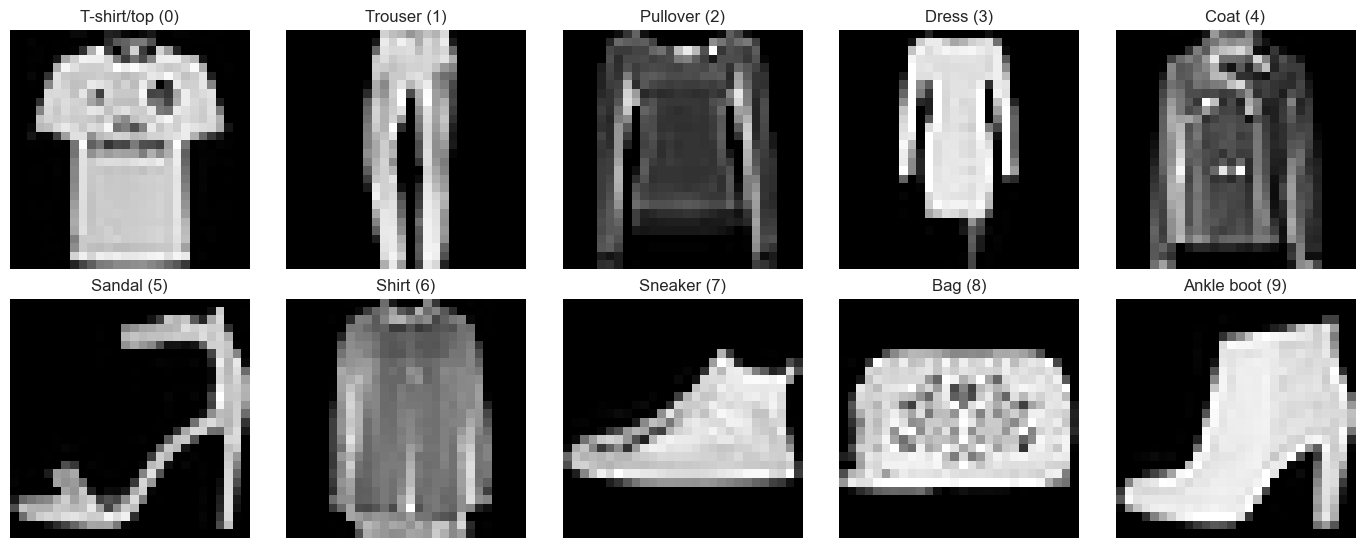

In [ ]:
# словарь названий классов Fashion-MNIST
FASHION_NAMES = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

def plot_one_per_class(X, y, img_side: int = 28):
    X = np.asarray(X)
    y = np.asarray(y)
    classes = np.unique(y)
    n = classes.size
    cols = min(5, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(2.8*cols, 2.8*rows))
    for i, c in enumerate(classes, 1):
        idx = np.where(y == c)[0][0]  # первый индекс класса
        img = X[idx].reshape(img_side, img_side)
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img, cmap="gray")
        name = FASHION_NAMES.get(int(c), str(c))
        ax.set_title(f"{name} ({int(c)})")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# вызов:
plot_one_per_class(X_train, y_train, img_side=28)


#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1) StandardScaler: (x - mean) / std, параметры считаем только по train
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std  = std_scaler.transform(X_test)

# 2) MinMaxScaler: приводим признаки к [0, 1] (по train)
mm_scaler = MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm  = mm_scaler.transform(X_test)

print("StandardScaler:", X_train_std.shape, X_test_std.shape)
print("MinMaxScaler:  ", X_train_mm.shape,  X_test_mm.shape)


StandardScaler: (5000, 784) (5000, 784)
MinMaxScaler:   (5000, 784) (5000, 784)


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
#KNN
#k (n_neighbors) — сколько соседей считать. Малый k = переобучение, большой k = слишком грубо. Поэтому ищем лучший.
#weights: uniform vs distance — считать ли ближних «сильнее» дальних (взвешенное голосование). Обычно distance работает лучше, но не всегда.
#метрика расстояния p: p=1  или p=2. В высоких размерностях выбор метрики важен, потому что евклидово расстояние (p=2) может быть менее информативным из-за «проклятия размерности». Манхэттенское (p=1) иногда работает лучше.
#Как итог, получаем k × weights × p, потому что эти вещи влияют вместе на поведение KNN.

# Logistic Regression
#penalty: тип регуляризации. l2 — классическая ридж-регуляризация, l1 — лассо (ведёт к разреженным решениям), elasticnet — смесь l1 и l2.
#C: обратный коэффициент регуляризации. Чем меньше C, тем сильнее регуляризация. Обычно ищем по логарифмической сетке.
#l1_ratio: только для elasticnet. Баланс между l1 и l2 (0.0 = только l2, 1.0 = только l1). Обычно ищем по равномерной сетке от 0 до 1 с шагом 0.25.
#class_weight: None или balanced. Если классы несбалансированы, balanced может помочь.




# Быстрый подбор гиперпараметров для KNN и LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

# ---------- 0) scale один раз (вне Pipeline) ----------
scaler = StandardScaler().fit(X_train)
Xtr = scaler.transform(X_train)
Xte = scaler.transform(X_test)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3 фолда быстрее и обычно достаточно

# ---------- 1) KNN: компактная, но осмысленная сетка ----------
knn = KNeighborsClassifier()
param_knn = {
    "n_neighbors": [3, 5, 7, 9, 15],
    "weights": ["uniform", "distance"],
    "p": [1, 2],  # L1 vs L2
}
gs_knn = GridSearchCV(knn, param_knn, scoring="accuracy", cv=cv, n_jobs=-1, verbose=2, refit=True)
gs_knn.fit(Xtr, y_train)
y_pred_knn = gs_knn.predict(Xte)
acc_knn = accuracy_score(y_test, y_pred_knn)

print("KNN best params:", gs_knn.best_params_)
print("KNN CV best accuracy:", gs_knn.best_score_)
print("KNN test accuracy:", acc_knn)
print(classification_report(y_test, y_pred_knn, digits=4))

# ---------- 2) Logistic Regression — две ветки ----------

# (A) Быстрая L2 (lbfgs + multinomial) — очень шустро и часто сильная база
lr_l2 = LogisticRegression(
    penalty="l2", solver="lbfgs", multi_class="multinomial",
    max_iter=400, tol=1e-4, n_jobs=-1
)
param_lr_l2 = {
    "C": 10.0 ** np.linspace(-3, 2, 6)  # 1e-3 .. 1e2, 6 точек
}
gs_lr_l2 = GridSearchCV(lr_l2, param_lr_l2, scoring="accuracy", cv=cv, n_jobs=-1, verbose=2, refit=True)
gs_lr_l2.fit(Xtr, y_train)
y_pred_lr_l2 = gs_lr_l2.predict(Xte)
acc_lr_l2 = accuracy_score(y_test, y_pred_lr_l2)

print("\nLR(L2) best params:", gs_lr_l2.best_params_)
print("LR(L2) CV best accuracy:", gs_lr_l2.best_score_)
print("LR(L2) test accuracy:", acc_lr_l2)
print(classification_report(y_test, y_pred_lr_l2, digits=4))

# (B) Разрежная ветка: L1/ElasticNet (saga). Урезанная сетка для скорости.
lr_sparse = LogisticRegression(
    solver="saga", max_iter=600, tol=1e-3, n_jobs=-1  # слабее точность -> быстрее сходимость
)
param_lr_sparse = [
    # чистая L1
    {"penalty": ["l1"], "C": 10.0 ** np.linspace(-3, 1, 5)},  # 1e-3..1e1
    # elasticnet с несколькими l1_ratio
    {"penalty": ["elasticnet"], "l1_ratio": [0.2, 0.5, 0.8], "C": 10.0 ** np.linspace(-3, 1, 5)},
]
gs_lr_sparse = GridSearchCV(lr_sparse, param_lr_sparse, scoring="accuracy", cv=cv, n_jobs=-1, verbose=2, refit=True)
gs_lr_sparse.fit(Xtr, y_train)
y_pred_lr_sparse = gs_lr_sparse.predict(Xte)
acc_lr_sparse = accuracy_score(y_test, y_pred_lr_sparse)

print("\nLR(sparse) best params:", gs_lr_sparse.best_params_)
print("LR(sparse) CV best accuracy:", gs_lr_sparse.best_score_)
print("LR(sparse) test accuracy:", acc_lr_sparse)
print(classification_report(y_test, y_pred_lr_sparse, digits=4))

# ---------- Сводная таблица ----------
summary = pd.DataFrame([
    {"Model": "KNN",             "CV acc": gs_knn.best_score_,      "Test acc": acc_knn},
    {"Model": "LR L2(lbfgs)",    "CV acc": gs_lr_l2.best_score_,    "Test acc": acc_lr_l2},
    {"Model": "LR L1/EN(saga)",  "CV acc": gs_lr_sparse.best_score_,"Test acc": acc_lr_sparse},
]).sort_values("Test acc", ascending=False).reset_index(drop=True)

summary


Fitting 3 folds for each of 20 candidates, totalling 60 fits
KNN best params: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
KNN CV best accuracy: 0.8053971438605436
KNN test accuracy: 0.817
              precision    recall  f1-score   support

           0     0.7306    0.8333    0.7786       498
           1     0.9878    0.9490    0.9680       510
           2     0.7393    0.7118    0.7253       510
           3     0.8874    0.8316    0.8586       493
           4     0.7118    0.7348    0.7231       494
           5     0.9880    0.8059    0.8877       510
           6     0.5533    0.5613    0.5573       481
           7     0.8228    0.8866    0.8535       529
           8     0.9585    0.8923    0.9242       492
           9     0.8428    0.9545    0.8951       483

    accuracy                         0.8170      5000
   macro avg     0.8222    0.8161    0.8171      5000
weighted avg     0.8235    0.8170    0.8182      5000

Fitting 3 folds for each of 6 candidates, total

C:\Users\edyar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



LR(L2) best params: {'C': np.float64(0.01)}
LR(L2) CV best accuracy: 0.829396905732899
LR(L2) test accuracy: 0.8394
              precision    recall  f1-score   support

           0     0.7955    0.7892    0.7923       498
           1     0.9778    0.9490    0.9632       510
           2     0.7671    0.7490    0.7579       510
           3     0.8493    0.8803    0.8645       493
           4     0.7416    0.8016    0.7704       494
           5     0.9115    0.8686    0.8896       510
           6     0.6074    0.5821    0.5945       481
           7     0.8801    0.8885    0.8843       529
           8     0.9466    0.9370    0.9418       492
           9     0.9080    0.9400    0.9237       483

    accuracy                         0.8394      5000
   macro avg     0.8385    0.8385    0.8382      5000
weighted avg     0.8396    0.8394    0.8392      5000

Fitting 3 folds for each of 20 candidates, totalling 60 fits

LR(sparse) best params: {'C': np.float64(0.1), 'l1_ratio': 0.5

,Model,CV acc,Test acc
0,LR L2(lbfgs),0.829397,0.8394
1,LR L1/EN(saga),0.825397,0.8358
2,KNN,0.805397,0.8170


## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

In [ ]:
'''
Что делает логистическая регрессия (SGD)?
1) У всех объектов логит одинаковый(потому что x у всех один и тот же) => и вероятность p = σ(z) тоже одинакова для всех.
2) Градиент по смещению: dL/dw0 = (1/N) * sum(p - y).
   При балансе классов (поровну 0 и 1) и p = 0.5 получаем sum(p - y) = 0,
   т.е. градиент по w0 = 0.
3) Градиент по весам: ∇w = (1/N) * X^T (p - y).
   Так как все строки X одинаковы, а среднее (p - y) = 0, получаем ∇w = 0.
4) Если инициализировать w=0, w0=0, то p = σ(0) = 0.5,
   и все градиенты уже равны нулю. SGD ничего не меняет — модель остаётся на старте.

ИТОГ:
1) Модель предсказывает одинаковую вероятность p = 0.5 для всех объектов.
2) При пороге 0.5 метки будут все 1 (или в реализации — половина 0/1 в зависимости от правила)
3) Добавление L2 на w ничего не меняет: оптимум всё равно w = 0,
  а w0 = 0 (чтобы p = 0.5). Если классы НЕ сбалансированы (доля единиц = π),
  оптимум —  w0 = log(π / (1 - π)), и опять же веса w = 0.
4) Причина: в признаках нет информации, все x одинаковые — разделяющей границы
  по признакам не существует, можно только сдвигом подогнать общую долю класса.
'''

'\nЧто делает логистическая регрессия (SGD)?\n1) У всех объектов логит одинаковый(потому что x у всех один и тот же) => и вероятность p = σ(z) тоже одинакова для всех.\n2) Градиент по смещению: dL/dw0 = (1/N) * sum(p - y).\n   При балансе классов (поровну 0 и 1) и p = 0.5 получаем sum(p - y) = 0,\n   т.е. градиент по w0 = 0.\n3) Градиент по весам: ∇w = (1/N) * X^T (p - y).\n   Так как все строки X одинаковы, а среднее (p - y) = 0, получаем ∇w = 0.\n4) Если инициализировать w=0, w0=0, то p = σ(0) = 0.5,\n   и все градиенты уже равны нулю. SGD ничего не меняет — модель остаётся на старте.\n\nИТОГ:\n1) Модель предсказывает одинаковую вероятность p = 0.5 для всех объектов.\n2) При пороге 0.5 метки будут все 1 (или в реализации — половина 0/1 в зависимости от правила)\n3) Добавление L2 на w ничего не меняет: оптимум всё равно w = 0,\n  а w0 = 0 (чтобы p = 0.5). Если классы НЕ сбалансированы (доля единиц = π),\n  оптимум —  w0 = log(π / (1 - π)), и опять же веса w = 0.\n4) Причина: в признак